In [76]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

import  yfinance as yf
from finta import TA

In [77]:
# Get historical OHLCV data for target ticker
etf_df = yf.download(
    "STW.AX, VAS.AX, SPY.AX", 
    period="max"
)

[*********************100%***********************]  3 of 3 completed


In [78]:
# Review data to see the date ranges
display(etf_df.head())
display(etf_df.tail())
display(etf_df.shape)
display(etf_df.index)


Adj Close                    Close                     High  \
              SPY.AX     STW.AX VAS.AX SPY.AX     STW.AX VAS.AX SPY.AX   
Date                                                                     
2008-01-02       NaN  61.169998    NaN    NaN  61.169998    NaN    NaN   
2008-01-03       NaN  60.590000    NaN    NaN  60.590000    NaN    NaN   
2008-01-04       NaN  60.740002    NaN    NaN  60.740002    NaN    NaN   
2008-01-07       NaN  59.349998    NaN    NaN  59.349998    NaN    NaN   
2008-01-08       NaN  59.020000    NaN    NaN  59.020000    NaN    NaN   

                                Low                     Open             \
               STW.AX VAS.AX SPY.AX     STW.AX VAS.AX SPY.AX     STW.AX   
Date                                                                      
2008-01-02  61.169998    NaN    NaN  61.169998    NaN    NaN  61.169998   
2008-01-03  60.590000    NaN    NaN  60.590000    NaN    NaN  60.590000   
2008-01-04  60.740002    NaN    NaN  60.740002    NaN    NaN  60.740002   
2008-01-07  59.349998    NaN    NaN  59.349998    NaN    NaN  59.349998   
2008-01-08  59.020000    NaN    NaN  59.020000    NaN    NaN  59.020000   

                  Volume                
           VAS.AX SPY.AX STW.AX VAS.AX  
Date                                    
2008-01-02    NaN    NaN      0    NaN  
2008-01-03    NaN    NaN      0    NaN  
2008-01-04    NaN    NaN      0    NaN  
2008-01-07    NaN    NaN      0    NaN  
2008-01-08    NaN    NaN      0    NaN

Adj Close                             Close             \
                SPY.AX     STW.AX     VAS.AX      SPY.AX     STW.AX   
Date                                                                  
2023-01-03  561.349976  62.669998  85.820000  561.349976  62.669998   
2023-01-04  560.500000  63.619999  87.190002  560.500000  63.619999   
2023-01-05  563.140015  63.779999  87.320000  563.140015  63.779999   
2023-01-06  563.669983  64.169998  87.870003  563.669983  64.169998   
2023-01-09  562.090027  64.519997  88.400002  562.090027  64.519997   

                             High                               Low  \
               VAS.AX      SPY.AX     STW.AX     VAS.AX      SPY.AX   
Date                                                                  
2023-01-03  85.820000  567.020020  63.849998  87.650002  561.260010   
2023-01-04  87.190002  567.000000  63.700001  87.199997  560.500000   
2023-01-05  87.320000  563.140015  64.080002  87.779999  561.000000   
2023-01-06  87.870003  563.750000  64.239998  87.970001  561.669983   
2023-01-09  88.400002  565.000000  64.849998  88.849998  561.210022   

                                        Open                       Volume  \
               STW.AX     VAS.AX      SPY.AX     STW.AX     VAS.AX SPY.AX   
Date                                                                        
2023-01-03  62.299999  85.239998  567.020020  63.830002  87.650002  168.0   
2023-01-04  63.060001  86.309998  564.950012  63.080002  86.389999   90.0   
2023-01-05  63.650002  87.150002  561.830017  63.900002  87.500000  127.0   
2023-01-06  63.720001  87.290001  563.030029  63.750000  87.389999  696.0   
2023-01-09  64.489998  88.330002  564.200012  64.660004  88.559998  220.0   

                              
            STW.AX    VAS.AX  
Date                          
2023-01-03  168559  310891.0  
2023-01-04   70793  113157.0  
2023-01-05   49284  138744.0  
2023-01-06  142703  162973.0  
2023-01-09   49512  194248.0

(3799, 18)

DatetimeIndex(['2008-01-02', '2008-01-03', '2008-01-04', '2008-01-07',
               '2008-01-08', '2008-01-09', '2008-01-10', '2008-01-11',
               '2008-01-14', '2008-01-15',
               ...
               '2022-12-22', '2022-12-23', '2022-12-28', '2022-12-29',
               '2022-12-30', '2023-01-03', '2023-01-04', '2023-01-05',
               '2023-01-06', '2023-01-09'],
              dtype='datetime64[ns]', name='Date', length=3799, freq=None)

In [79]:
# Examine the column type and check for nulls
etf_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3799 entries, 2008-01-02 to 2023-01-09
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (Adj Close, SPY.AX)  2083 non-null   float64
 1   (Adj Close, STW.AX)  3799 non-null   float64
 2   (Adj Close, VAS.AX)  3462 non-null   float64
 3   (Close, SPY.AX)      2083 non-null   float64
 4   (Close, STW.AX)      3799 non-null   float64
 5   (Close, VAS.AX)      3462 non-null   float64
 6   (High, SPY.AX)       2083 non-null   float64
 7   (High, STW.AX)       3799 non-null   float64
 8   (High, VAS.AX)       3462 non-null   float64
 9   (Low, SPY.AX)        2083 non-null   float64
 10  (Low, STW.AX)        3799 non-null   float64
 11  (Low, VAS.AX)        3462 non-null   float64
 12  (Open, SPY.AX)       2083 non-null   float64
 13  (Open, STW.AX)       3799 non-null   float64
 14  (Open, VAS.AX)       3462 non-null   float64
 15  (Volume, SPY.AX)    

In [80]:
short_window = 20
long_window = 200

# Generate Entry/Exit points for all 3 ETFs

## Entry/Exit points for SPY

In [83]:
etf_new_df = etf_df.copy()

etf_new_df.columns = etf_new_df.columns.swaplevel()

etf_new_df = etf_new_df.dropna()

etf_new_df.head()

,SPY.AX,STW.AX,VAS.AX,SPY.AX,STW.AX,VAS.AX,SPY.AX,STW.AX,VAS.AX,SPY.AX,STW.AX,VAS.AX,SPY.AX,STW.AX,VAS.AX,SPY.AX,STW.AX,VAS.AX
,Adj Close,Adj Close,Adj Close,Close,Close,Close,High,High,High,Low,Low,Low,Open,Open,Open,Volume,Volume,Volume
Date,,,,,,,,,,,,,,,,,,
2014-10-13,216.729996,48.599998,65.360001,216.729996,48.599998,65.360001,218.380005,48.700001,65.500000,216.199997,48.200001,64.959999,218.149994,48.259998,65.110001,5140.0,177654,38801.0
2014-10-14,213.949997,49.119999,66.059998,213.949997,49.119999,66.059998,214.660004,49.220001,66.160004,213.949997,48.320000,65.029999,214.000000,48.340000,65.260002,3320.0,136290,28254.0
2014-10-15,217.089996,49.500000,66.480003,217.089996,49.500000,66.480003,217.089996,49.529999,66.580002,216.630005,49.029999,66.000000,216.630005,49.160000,66.059998,1230.0,164068,38596.0
2014-10-16,212.434738,49.549999,66.599998,212.434738,49.549999,66.599998,212.434738,49.599998,66.669998,212.434738,48.700001,65.459999,212.434738,49.020000,66.019997,0.0,333351,28965.0
2014-10-17,213.059998,49.779999,66.839996,213.059998,49.779999,66.839996,213.059998,50.060001,67.260002,212.419998,49.669998,66.730003,212.419998,49.730000,66.730003,1622.0,112079,26288.0


In [7]:
spy_etf_df = etf_new_df['SPY.AX']
spy_etf_df["Short"] = TA.SMA(spy_etf_df, short_window)
spy_etf_df["Long"] = TA.SMA(spy_etf_df, long_window)

spy_etf_df = spy_etf_df.dropna()

/var/folders/8d/w8z1f6b138d2wpdqrltnk8180000gn/T/ipykernel_32043/2511558147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_etf_df["Short"] = TA.SMA(spy_etf_df, short_window)
/var/folders/8d/w8z1f6b138d2wpdqrltnk8180000gn/T/ipykernel_32043/2511558147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_etf_df["Long"] = TA.SMA(spy_etf_df, long_window)


In [8]:
spy_etf_df["Signal"] = 0.0

spy_etf_df["Signal"][short_window:] = np.where(
    spy_etf_df["Short"][short_window:] > spy_etf_df["Long"][short_window:], 1.0, 0.0
)

spy_etf_df["Entry/Exit"] = spy_etf_df["Signal"].diff()

spy_etf_df.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,
2015-07-29,285.339996,285.339996,285.579987,285.339996,285.579987,363.0,282.070500,259.898916,0.0,NaN
2015-07-30,288.000000,288.000000,288.350006,287.739990,288.350006,173.0,282.899001,260.255266,0.0,0.0
2015-07-31,289.040009,289.040009,289.059998,289.010010,289.010010,384.0,283.670001,260.630716,0.0,0.0
2015-08-03,288.320007,288.320007,289.010010,288.320007,289.010010,198.0,284.383002,260.986866,0.0,0.0
2015-08-04,285.500000,285.500000,285.500000,285.500000,285.500000,30.0,284.766002,261.352193,0.0,0.0


In [9]:
# Visualize entry position relative to close price
spy_entry = spy_etf_df[spy_etf_df["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
spy_exit = spy_etf_df[spy_etf_df["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='orange',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
spy_security_close = spy_etf_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
spy_moving_avgs = spy_etf_df[["Short", "Long"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
spy_entry_exit_plot = spy_security_close * spy_moving_avgs * spy_entry * spy_exit
spy_entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Entry/Exit points for STW

In [10]:
stw_etf_df = etf_new_df['STW.AX']
stw_etf_df["Short"] = TA.SMA(stw_etf_df, short_window)
stw_etf_df["Long"] = TA.SMA(stw_etf_df, long_window)

stw_etf_df = stw_etf_df.dropna()

/var/folders/8d/w8z1f6b138d2wpdqrltnk8180000gn/T/ipykernel_32043/2158732949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stw_etf_df["Short"] = TA.SMA(stw_etf_df, short_window)
/var/folders/8d/w8z1f6b138d2wpdqrltnk8180000gn/T/ipykernel_32043/2158732949.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stw_etf_df["Long"] = TA.SMA(stw_etf_df, long_window)


In [11]:
stw_etf_df["Signal"] = 0.0

stw_etf_df["Signal"][short_window:] = np.where(
    stw_etf_df["Short"][short_window:] > stw_etf_df["Long"][short_window:], 1.0, 0.0
)

stw_etf_df["Entry/Exit"] = stw_etf_df["Signal"].diff()

stw_etf_df.head()

/var/folders/8d/w8z1f6b138d2wpdqrltnk8180000gn/T/ipykernel_32043/1662391487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stw_etf_df["Signal"][short_window:] = np.where(


,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,
2015-07-29,52.520000,52.520000,52.750000,52.490002,52.700001,84266,52.0730,52.61950,0.0,NaN
2015-07-30,52.919998,52.919998,52.980000,52.720001,52.799999,74214,52.1060,52.64110,0.0,0.0
2015-07-31,53.160000,53.160000,53.209999,53.020000,53.020000,54302,52.1835,52.66130,0.0,0.0
2015-08-03,52.930000,52.930000,53.250000,52.910000,53.250000,36108,52.2760,52.67845,0.0,0.0
2015-08-04,53.150002,53.150002,53.480000,52.799999,52.950001,1688292,52.3310,52.69645,0.0,0.0


In [12]:
# Visualize entry position relative to close price
stw_entry = stw_etf_df[stw_etf_df["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
stw_exit = stw_etf_df[stw_etf_df["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='orange',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
stw_security_close = stw_etf_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
stw_moving_avgs = stw_etf_df[["Short", "Long"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
stw_entry_exit_plot = stw_security_close * stw_moving_avgs * stw_entry * stw_exit
stw_entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Entry/Exit points for VAS

In [13]:
vas_etf_df = etf_new_df['VAS.AX']
vas_etf_df["Short"] = TA.SMA(vas_etf_df, short_window)
vas_etf_df["Long"] = TA.SMA(vas_etf_df, long_window)

vas_etf_df = vas_etf_df.dropna()

/var/folders/8d/w8z1f6b138d2wpdqrltnk8180000gn/T/ipykernel_32043/1495452757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vas_etf_df["Short"] = TA.SMA(vas_etf_df, short_window)
/var/folders/8d/w8z1f6b138d2wpdqrltnk8180000gn/T/ipykernel_32043/1495452757.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vas_etf_df["Long"] = TA.SMA(vas_etf_df, long_window)


In [14]:
vas_etf_df["Signal"] = 0.0

vas_etf_df["Signal"][short_window:] = np.where(
    vas_etf_df["Short"][short_window:] > vas_etf_df["Long"][short_window:], 1.0, 0.0
)

vas_etf_df["Entry/Exit"] = vas_etf_df["Signal"].diff()

vas_etf_df.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,
2015-07-29,71.370003,71.370003,71.769997,71.250000,71.449997,30067.0,70.8450,71.27085,0.0,NaN
2015-07-30,71.959999,71.959999,71.959999,71.410004,71.410004,39040.0,70.8915,71.30385,0.0,0.0
2015-07-31,72.099998,72.099998,72.260002,72.000000,72.000000,36925.0,70.9855,71.33405,0.0,0.0
2015-08-03,71.949997,71.949997,72.489998,71.889999,72.489998,45618.0,71.1015,71.36140,0.0,0.0
2015-08-04,72.269997,72.269997,72.599998,71.849998,72.010002,64205.0,71.1755,71.38975,0.0,0.0


In [15]:
# Visualize entry position relative to close price
vas_entry = vas_etf_df[vas_etf_df["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
vas_exit = vas_etf_df[vas_etf_df["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='orange',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
vas_security_close = vas_etf_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
vas_moving_avgs = vas_etf_df[["Short", "Long"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
vas_entry_exit_plot = vas_security_close * vas_moving_avgs * vas_entry * vas_exit
vas_entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

# Calculating Actual Returns and Strategy Returns for all 3 ETFs

In [16]:
# Retain the key columns for each etf
etf_df = etf_df.drop(columns = ['Adj Close', 'High', 'Low', 'Open', 'Volume'])
etf_df.columns = etf_df.columns.droplevel()     # Changes the multilevel indexing on columns to single level

In [17]:
etf_df.head()

,SPY.AX,STW.AX,VAS.AX
Date,,,
2008-01-02,NaN,61.169998,NaN
2008-01-03,NaN,60.590000,NaN
2008-01-04,NaN,60.740002,NaN
2008-01-07,NaN,59.349998,NaN
2008-01-08,NaN,59.020000,NaN


In [18]:
#  Drop all nulls
etf_df = etf_df.dropna()
etf_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2082 entries, 2014-10-13 to 2023-01-09
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY.AX  2082 non-null   float64
 1   STW.AX  2082 non-null   float64
 2   VAS.AX  2082 non-null   float64
dtypes: float64(3)
memory usage: 65.1 KB


In [19]:
etf_df.head()

,SPY.AX,STW.AX,VAS.AX
Date,,,
2014-10-13,216.729996,48.599998,65.360001
2014-10-14,213.949997,49.119999,66.059998
2014-10-15,217.089996,49.500000,66.480003
2014-10-16,212.434738,49.549999,66.599998
2014-10-17,213.059998,49.779999,66.839996


In [20]:
# choose the short and long windows

short_window = 20
long_window = 200

## Calculate Actual Returns, Strategy Returns for all the 3 ETFs

In [21]:
# Calculate Daily actual returns for each ETF

etf_df['SPY Actual Returns'] = etf_df['SPY.AX'].pct_change()
etf_df['STW Actual Returns'] = etf_df['STW.AX'].pct_change()
etf_df['VAS Actual Returns'] = etf_df['VAS.AX'].pct_change()
display(etf_df.head())
#display(etf_df.info())

,SPY.AX,STW.AX,VAS.AX,SPY Actual Returns,STW Actual Returns,VAS Actual Returns
Date,,,,,,
2014-10-13,216.729996,48.599998,65.360001,NaN,NaN,NaN
2014-10-14,213.949997,49.119999,66.059998,-0.012827,0.010700,0.010710
2014-10-15,217.089996,49.500000,66.480003,0.014676,0.007736,0.006358
2014-10-16,212.434738,49.549999,66.599998,-0.021444,0.001010,0.001805
2014-10-17,213.059998,49.779999,66.839996,0.002943,0.004642,0.003604


In [22]:
# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
etf_df['SPY_SMA_Fast'] = etf_df['SPY.AX'].rolling(window=short_window).mean()
etf_df['SPY_SMA_Slow'] = etf_df['SPY.AX'].rolling(window=long_window).mean()

etf_df['STW_SMA_Fast'] = etf_df['STW.AX'].rolling(window=short_window).mean()
etf_df['STW_SMA_Slow'] = etf_df['STW.AX'].rolling(window=long_window).mean()

etf_df['VAS_SMA_Fast'] = etf_df['VAS.AX'].rolling(window=short_window).mean()
etf_df['VAS_SMA_Slow'] = etf_df['VAS.AX'].rolling(window=long_window).mean()

etf_df = etf_df.dropna()

#display(etf_df)  -- to verify the number of rows

display(etf_df.head())
display(etf_df.tail())

,SPY.AX,STW.AX,VAS.AX,SPY Actual Returns,STW Actual Returns,VAS Actual Returns,SPY_SMA_Fast,SPY_SMA_Slow,STW_SMA_Fast,STW_SMA_Slow,VAS_SMA_Fast,VAS_SMA_Slow
Date,,,,,,,,,,,,
2015-07-29,285.339996,52.520000,71.370003,0.000701,0.008255,0.009191,282.070500,259.898916,52.0730,52.61950,70.8450,71.27085
2015-07-30,288.000000,52.919998,71.959999,0.009322,0.007616,0.008267,282.899001,260.255266,52.1060,52.64110,70.8915,71.30385
2015-07-31,289.040009,53.160000,72.099998,0.003611,0.004535,0.001946,283.670001,260.630716,52.1835,52.66130,70.9855,71.33405
2015-08-03,288.320007,52.930000,71.949997,-0.002491,-0.004327,-0.002080,284.383002,260.986866,52.2760,52.67845,71.1015,71.36140
2015-08-04,285.500000,53.150002,72.269997,-0.009781,0.004156,0.004448,284.766002,261.352193,52.3310,52.69645,71.1755,71.38975


,SPY.AX,STW.AX,VAS.AX,SPY Actual Returns,STW Actual Returns,VAS Actual Returns,SPY_SMA_Fast,SPY_SMA_Slow,STW_SMA_Fast,STW_SMA_Slow,VAS_SMA_Fast,VAS_SMA_Slow
Date,,,,,,,,,,,,
2023-01-03,561.349976,62.669998,85.820000,-0.006460,-0.013226,-0.021437,579.018497,581.13870,65.012999,64.21775,89.058500,88.01225
2023-01-04,560.500000,63.619999,87.190002,-0.001514,0.015159,0.015964,577.174997,580.98080,64.872499,64.19460,88.872001,87.97715
2023-01-05,563.140015,63.779999,87.320000,0.004710,0.002515,0.001491,575.597998,580.80150,64.729499,64.17225,88.676500,87.94230
2023-01-06,563.669983,64.169998,87.870003,0.000941,0.006115,0.006299,574.045996,580.62335,64.620499,64.14900,88.530000,87.90595
2023-01-09,562.090027,64.519997,88.400002,-0.002803,0.005454,0.006032,572.673499,580.41950,64.559499,64.12550,88.450500,87.86975


In [23]:
# Initialize the Signal column for all 3 ETFs

etf_df['SPY Signal'] = 0.0
etf_df['STW Signal'] = 0.0
etf_df['VAS Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy ETFs long

etf_df.loc[(etf_df['SPY Actual Returns'] >= 0), 'SPY Signal'] = 1
etf_df.loc[(etf_df['STW Actual Returns'] >= 0), 'STW Signal'] = 1
etf_df.loc[(etf_df['VAS Actual Returns'] >= 0), 'VAS Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell ETFs short

etf_df.loc[(etf_df['SPY Actual Returns'] < 0), 'SPY Signal'] = -1
etf_df.loc[(etf_df['STW Actual Returns'] < 0), 'STW Signal'] = -1
etf_df.loc[(etf_df['VAS Actual Returns'] < 0), 'VAS Signal'] = -1

etf_df.head()


,SPY.AX,STW.AX,VAS.AX,SPY Actual Returns,STW Actual Returns,VAS Actual Returns,SPY_SMA_Fast,SPY_SMA_Slow,STW_SMA_Fast,STW_SMA_Slow,VAS_SMA_Fast,VAS_SMA_Slow,SPY Signal,STW Signal,VAS Signal
Date,,,,,,,,,,,,,,,
2015-07-29,285.339996,52.520000,71.370003,0.000701,0.008255,0.009191,282.070500,259.898916,52.0730,52.61950,70.8450,71.27085,1.0,1.0,1.0
2015-07-30,288.000000,52.919998,71.959999,0.009322,0.007616,0.008267,282.899001,260.255266,52.1060,52.64110,70.8915,71.30385,1.0,1.0,1.0
2015-07-31,289.040009,53.160000,72.099998,0.003611,0.004535,0.001946,283.670001,260.630716,52.1835,52.66130,70.9855,71.33405,1.0,1.0,1.0
2015-08-03,288.320007,52.930000,71.949997,-0.002491,-0.004327,-0.002080,284.383002,260.986866,52.2760,52.67845,71.1015,71.36140,-1.0,-1.0,-1.0
2015-08-04,285.500000,53.150002,72.269997,-0.009781,0.004156,0.004448,284.766002,261.352193,52.3310,52.69645,71.1755,71.38975,-1.0,1.0,1.0


In [24]:
etf_df['SPY Signal'].value_counts()

 1.0    1041
-1.0     842
Name: SPY Signal, dtype: int64

In [25]:
etf_df['STW Signal'].value_counts()

 1.0    1044
-1.0     839
Name: STW Signal, dtype: int64

In [26]:
etf_df['VAS Signal'].value_counts()

 1.0    1042
-1.0     841
Name: VAS Signal, dtype: int64

In [27]:
# Calculate the Strategic Returns for all the 3 ETFs

etf_df['SPY Strategy Returns'] = etf_df['SPY Actual Returns'] * etf_df['SPY Signal'].shift()
etf_df['STW Strategy Returns'] = etf_df['STW Actual Returns'] * etf_df['STW Signal'].shift()
etf_df['VAS Strategy Returns'] = etf_df['VAS Actual Returns'] * etf_df['VAS Signal'].shift()
etf_df.head()

,SPY.AX,STW.AX,VAS.AX,SPY Actual Returns,STW Actual Returns,VAS Actual Returns,SPY_SMA_Fast,SPY_SMA_Slow,STW_SMA_Fast,STW_SMA_Slow,VAS_SMA_Fast,VAS_SMA_Slow,SPY Signal,STW Signal,VAS Signal,SPY Strategy Returns,STW Strategy Returns,VAS Strategy Returns
Date,,,,,,,,,,,,,,,,,,
2015-07-29,285.339996,52.520000,71.370003,0.000701,0.008255,0.009191,282.070500,259.898916,52.0730,52.61950,70.8450,71.27085,1.0,1.0,1.0,NaN,NaN,NaN
2015-07-30,288.000000,52.919998,71.959999,0.009322,0.007616,0.008267,282.899001,260.255266,52.1060,52.64110,70.8915,71.30385,1.0,1.0,1.0,0.009322,0.007616,0.008267
2015-07-31,289.040009,53.160000,72.099998,0.003611,0.004535,0.001946,283.670001,260.630716,52.1835,52.66130,70.9855,71.33405,1.0,1.0,1.0,0.003611,0.004535,0.001946
2015-08-03,288.320007,52.930000,71.949997,-0.002491,-0.004327,-0.002080,284.383002,260.986866,52.2760,52.67845,71.1015,71.36140,-1.0,-1.0,-1.0,-0.002491,-0.004327,-0.002080
2015-08-04,285.500000,53.150002,72.269997,-0.009781,0.004156,0.004448,284.766002,261.352193,52.3310,52.69645,71.1755,71.38975,-1.0,1.0,1.0,0.009781,-0.004156,-0.004448


<AxesSubplot:title={'center':'Strategy Returns for SPY, STW and VAS'}, xlabel='Date'>

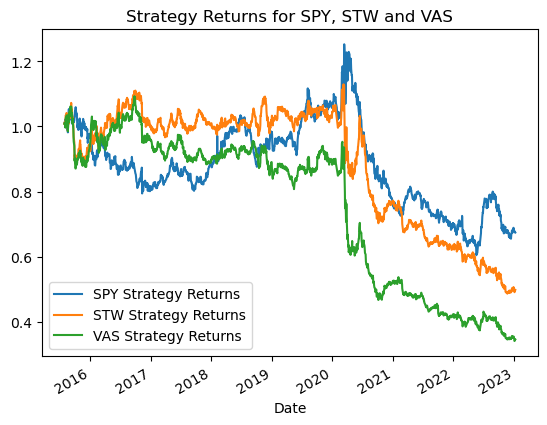

In [28]:
# Plot the cumulative returns for all the 3 ETFs

(1 + etf_df[['SPY Strategy Returns','STW Strategy Returns','VAS Strategy Returns']]).cumprod().plot(title = "Strategy Returns for SPY, STW and VAS")

## Create training and testing data sets for all 3 ETFs

In [29]:
# Create training data sets for SPY using the respective SMA Fast and SMA Slow columns
X = etf_df[['SPY_SMA_Fast', 'SPY_SMA_Slow']].shift().dropna()
X.head()

,SPY_SMA_Fast,SPY_SMA_Slow
Date,,
2015-07-30,282.070500,259.898916
2015-07-31,282.899001,260.255266
2015-08-03,283.670001,260.630716
2015-08-04,284.383002,260.986866
2015-08-05,284.766002,261.352193


In [30]:
# Create testing data sets using signal columns of SPY

y = etf_df[['SPY Signal']]
y.head()

,SPY Signal
Date,
2015-07-29,1.0
2015-07-30,1.0
2015-07-31,1.0
2015-08-03,-1.0
2015-08-04,-1.0


In [31]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-07-30 00:00:00


In [32]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-10-30 00:00:00


In [33]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SPY_SMA_Fast,SPY_SMA_Slow
Date,,
2015-07-30,282.070500,259.898916
2015-07-31,282.899001,260.255266
2015-08-03,283.670001,260.630716
2015-08-04,284.383002,260.986866
2015-08-05,284.766002,261.352193


In [34]:
# Generate the X_test and y_test DataFrames
#X_test = X.loc[training_end+DateOffset(hours=1):]
#y_test = y.loc[training_end+DateOffset(hours=1):]

X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Review the X_test DataFrame
display(X_train.head())
display(X_train.tail())

,SPY_SMA_Fast,SPY_SMA_Slow
Date,,
2015-07-30,282.070500,259.898916
2015-07-31,282.899001,260.255266
2015-08-03,283.670001,260.630716
2015-08-04,284.383002,260.986866
2015-08-05,284.766002,261.352193


,SPY_SMA_Fast,SPY_SMA_Slow
Date,,
2015-10-26,276.332396,272.332240
2015-10-27,276.942384,272.519689
2015-10-28,277.721005,272.708001
2015-10-29,278.734505,272.929501
2015-10-30,279.832504,273.172651


In [35]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [36]:
# From SVM, instantiate SVC classifier model instance
from sklearn.svm import SVC

spy_svm_model = SVC()
 
# Fit the model to the data using the training data
spy_svm_model = spy_svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
spy_svm_pred = spy_svm_model.predict(X_test_scaled)

# Review the model's predicted values
print(spy_svm_pred)


[1. 1. 1. ... 1. 1. 1.]


/usr/local/anaconda3/envs/cenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
# Use a classification report to evaluate the model using the predictions and testing data
spy_svm_testing_report = classification_report(y_test,spy_svm_pred)

# Print the classification report
print(spy_svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       810
         1.0       0.55      1.00      0.71      1006

    accuracy                           0.55      1816
   macro avg       0.28      0.50      0.36      1816
weighted avg       0.31      0.55      0.39      1816



/usr/local/anaconda3/envs/cenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/cenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/envs/cenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
spy_predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
spy_predictions_df['SPY Pred'] = spy_svm_pred

# Add the actual returns to the DataFrame
spy_predictions_df['SPY Actual Returns'] = etf_df["SPY Actual Returns"]

# Add the strategy returns to the DataFrame
spy_predictions_df['SPY Strategy Returns'] = (spy_predictions_df["SPY Actual Returns"] * spy_predictions_df['SPY Pred'])

# Review the DataFrame
display(spy_predictions_df.head())
display(spy_predictions_df.tail())

,SPY Pred,SPY Actual Returns,SPY Strategy Returns
Date,,,
2015-10-30,1.0,0.004051,0.004051
2015-11-02,1.0,-0.015258,-0.015258
2015-11-03,1.0,0.013174,0.013174
2015-11-04,1.0,-0.001234,-0.001234
2015-11-05,1.0,0.000611,0.000611


,SPY Pred,SPY Actual Returns,SPY Strategy Returns
Date,,,
2023-01-03,1.0,-0.006460,-0.006460
2023-01-04,1.0,-0.001514,-0.001514
2023-01-05,1.0,0.004710,0.004710
2023-01-06,1.0,0.000941,0.000941
2023-01-09,1.0,-0.002803,-0.002803


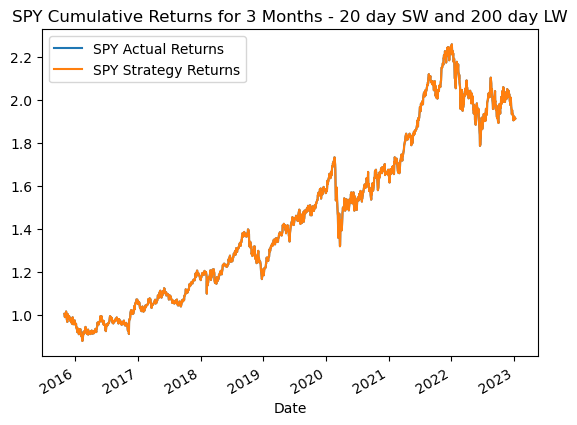

In [39]:
# Plot the actual returns versus the strategy returns
spy_plt_ar_sr = (1 + spy_predictions_df[["SPY Actual Returns", "SPY Strategy Returns"]]).cumprod().plot(title="SPY Cumulative Returns for 3 Months - 20 day SW and 200 day LW")
#plt.savefig('SPY_CumPlot_6Mon_4SW_100LW.png')

In [40]:
# Create training data sets for STW using the respective SMA Fast and SMA Slow columns
X1 = etf_df[['STW_SMA_Fast', 'STW_SMA_Slow']].shift().dropna()
X1.head()

,STW_SMA_Fast,STW_SMA_Slow
Date,,
2015-07-30,52.0730,52.61950
2015-07-31,52.1060,52.64110
2015-08-03,52.1835,52.66130
2015-08-04,52.2760,52.67845
2015-08-05,52.3310,52.69645


In [41]:
# Create the test data set for STW using the respective Signal column
y1 = etf_df[['STW Signal']]
y1.head()

,STW Signal
Date,
2015-07-29,1.0
2015-07-30,1.0
2015-07-31,1.0
2015-08-03,-1.0
2015-08-04,1.0


In [42]:
# Generate the X_train and y_train DataFrames
X1_train = X1.loc[training_begin:training_end]
y1_train = y1.loc[training_begin:training_end]

# Review the X_train DataFrame
X1_train.head()

,STW_SMA_Fast,STW_SMA_Slow
Date,,
2015-07-30,52.0730,52.61950
2015-07-31,52.1060,52.64110
2015-08-03,52.1835,52.66130
2015-08-04,52.2760,52.67845
2015-08-05,52.3310,52.69645


In [43]:
# Generate the X_test and y_test DataFrames
#X1_test = X1.loc[training_end+DateOffset(hours=1):]
#y1_test = y1.loc[training_end+DateOffset(hours=1):]

X1_test = X1.loc[training_end:]
y1_test = y1.loc[training_end:]

# Review the X_test DataFrame
display(X1_train.head())
display(X1_train.tail())

,STW_SMA_Fast,STW_SMA_Slow
Date,,
2015-07-30,52.0730,52.61950
2015-07-31,52.1060,52.64110
2015-08-03,52.1835,52.66130
2015-08-04,52.2760,52.67845
2015-08-05,52.3310,52.69645


,STW_SMA_Fast,STW_SMA_Slow
Date,,
2015-10-26,49.1165,52.19430
2015-10-27,49.2280,52.19620
2015-10-28,49.4330,52.19990
2015-10-29,49.5805,52.20455
2015-10-30,49.6525,52.20695


In [44]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler1 = StandardScaler()

# Apply the scaler model to fit the X-train data
X1_scaler = scaler1.fit(X1_train)

# Transform the X1_train and X1_test DataFrames using the X1_scaler
X1_train_scaled = X1_scaler.transform(X1_train)
X1_test_scaled = X1_scaler.transform(X1_test)

In [45]:
# From SVM, instantiate SVC classifier model instance
from sklearn.svm import SVC

stw_svm_model = SVC()
 
# Fit the model to the data using the training data
stw_svm_model = stw_svm_model.fit(X1_train_scaled, y1_train)
 
# Use the testing data to make the model predictions
stw_svm_pred = stw_svm_model.predict(X1_test_scaled)

# Review the model's predicted values
print(stw_svm_pred)

[1. 1. 1. ... 1. 1. 1.]


/usr/local/anaconda3/envs/cenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
# Use a classification report to evaluate the model using the predictions and testing data
stw_svm_testing_report = classification_report(y1_test,stw_svm_pred)

# Print the classification report
print(stw_svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.39      0.02      0.03       810
         1.0       0.55      0.98      0.71      1006

    accuracy                           0.55      1816
   macro avg       0.47      0.50      0.37      1816
weighted avg       0.48      0.55      0.41      1816



In [47]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
stw_predictions_df = pd.DataFrame(index=X1_test.index)

# Add the SVM model predictions to the DataFrame
stw_predictions_df['STW Pred'] = stw_svm_pred

# Add the actual returns to the DataFrame
stw_predictions_df['STW Actual Returns'] = etf_df["STW Actual Returns"]

# Add the strategy returns to the DataFrame
stw_predictions_df['STW Strategy Returns'] = (stw_predictions_df["STW Actual Returns"] * stw_predictions_df['STW Pred'])

# Review the DataFrame
display(stw_predictions_df.head())
display(stw_predictions_df.tail())

,STW Pred,STW Actual Returns,STW Strategy Returns
Date,,,
2015-10-30,1.0,-0.004411,-0.004411
2015-11-02,1.0,-0.013897,-0.013897
2015-11-03,1.0,0.014297,0.014297
2015-11-04,1.0,0.000000,0.000000
2015-11-05,1.0,-0.008055,-0.008055


,STW Pred,STW Actual Returns,STW Strategy Returns
Date,,,
2023-01-03,1.0,-0.013226,-0.013226
2023-01-04,1.0,0.015159,0.015159
2023-01-05,1.0,0.002515,0.002515
2023-01-06,1.0,0.006115,0.006115
2023-01-09,1.0,0.005454,0.005454


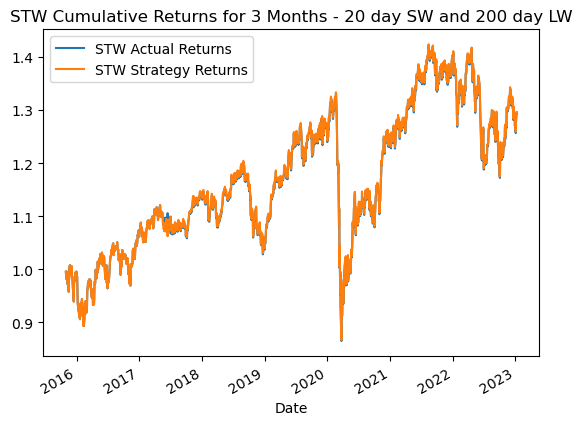

In [48]:
# Plot the actual returns versus the strategy returns
stw_plt_ar_sr = (1 + stw_predictions_df[["STW Actual Returns", "STW Strategy Returns"]]).cumprod().plot(title="STW Cumulative Returns for 3 Months - 20 day SW and 200 day LW")
#plt.savefig('SPY_CumPlot_6Mon_4SW_100LW.png')

In [49]:
# Create training data sets for VAS using the respective SMA Fast and SMA Slow columns
X2 = etf_df[['VAS_SMA_Fast', 'VAS_SMA_Slow']].shift().dropna()
X2.head()

,VAS_SMA_Fast,VAS_SMA_Slow
Date,,
2015-07-30,70.8450,71.27085
2015-07-31,70.8915,71.30385
2015-08-03,70.9855,71.33405
2015-08-04,71.1015,71.36140
2015-08-05,71.1755,71.38975


In [50]:
# Create the test data set for VAS using the respective Signal column
y2 = etf_df[['VAS Signal']]
y2.head()

,VAS Signal
Date,
2015-07-29,1.0
2015-07-30,1.0
2015-07-31,1.0
2015-08-03,-1.0
2015-08-04,1.0


In [51]:
# Generate the X2_train and y2_train DataFrames
X2_train = X2.loc[training_begin:training_end]
y2_train = y2.loc[training_begin:training_end]

# Review the X2_train DataFrame
X2_train.head()

,VAS_SMA_Fast,VAS_SMA_Slow
Date,,
2015-07-30,70.8450,71.27085
2015-07-31,70.8915,71.30385
2015-08-03,70.9855,71.33405
2015-08-04,71.1015,71.36140
2015-08-05,71.1755,71.38975


In [52]:
# Generate the X_test and y_test DataFrames
#X2_test = X2.loc[training_end+DateOffset(hours=1):]
#y2_test = y2.loc[training_end+DateOffset(hours=1):]

X2_test = X2.loc[training_end:]
y2_test = y2.loc[training_end:]


# Review the X_test DataFrame
display(X2_train.head())
display(X2_train.tail())

,VAS_SMA_Fast,VAS_SMA_Slow
Date,,
2015-07-30,70.8450,71.27085
2015-07-31,70.8915,71.30385
2015-08-03,70.9855,71.33405
2015-08-04,71.1015,71.36140
2015-08-05,71.1755,71.38975


,VAS_SMA_Fast,VAS_SMA_Slow
Date,,
2015-10-26,66.0875,70.85610
2015-10-27,66.2075,70.85465
2015-10-28,66.4270,70.85345
2015-10-29,66.5995,70.85530
2015-10-30,66.7065,70.85465


In [53]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler2 = StandardScaler()

# Apply the scaler model to fit the X2-train data
X2_scaler = scaler2.fit(X2_train)

# Transform the X2_train and X2_test DataFrames using the X2_scaler
X2_train_scaled = X2_scaler.transform(X2_train)
X2_test_scaled = X2_scaler.transform(X2_test)

In [54]:
# From SVM, instantiate SVC classifier model instance
from sklearn.svm import SVC

vas_svm_model = SVC()
 
# Fit the model to the data using the training data
vas_svm_model = vas_svm_model.fit(X2_train_scaled, np.ravel(y2_train, order='C'))
 
# Use the testing data to make the model predictions
vas_svm_pred = vas_svm_model.predict(X2_test_scaled)

# Review the model's predicted values
print(vas_svm_pred)

[1. 1. 1. ... 1. 1. 1.]


In [55]:
# Use a classification report to evaluate the model using the predictions and testing data
vas_svm_testing_report = classification_report(y2_test,vas_svm_pred,zero_division=1)

# Print the classification report
print(vas_svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.49      0.03      0.05       811
         1.0       0.55      0.98      0.71      1005

    accuracy                           0.55      1816
   macro avg       0.52      0.50      0.38      1816
weighted avg       0.53      0.55      0.42      1816



In [56]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
vas_predictions_df = pd.DataFrame(index=X2_test.index)

# Add the SVM model predictions to the DataFrame
vas_predictions_df['VAS Pred'] = vas_svm_pred

# Add the actual returns to the DataFrame
vas_predictions_df['VAS Actual Returns'] = etf_df["VAS Actual Returns"]

# Add the strategy returns to the DataFrame
vas_predictions_df['VAS Strategy Returns'] = (vas_predictions_df["VAS Actual Returns"] * vas_predictions_df['VAS Pred'])

# Review the DataFrame
display(vas_predictions_df.head())
display(vas_predictions_df.tail())

,VAS Pred,VAS Actual Returns,VAS Strategy Returns
Date,,,
2015-10-30,1.0,-0.006544,-0.006544
2015-11-02,1.0,-0.015719,-0.015719
2015-11-03,1.0,0.011407,0.011407
2015-11-04,1.0,0.003007,0.003007
2015-11-05,1.0,-0.006897,-0.006897


,VAS Pred,VAS Actual Returns,VAS Strategy Returns
Date,,,
2023-01-03,1.0,-0.021437,-0.021437
2023-01-04,1.0,0.015964,0.015964
2023-01-05,1.0,0.001491,0.001491
2023-01-06,1.0,0.006299,0.006299
2023-01-09,1.0,0.006032,0.006032


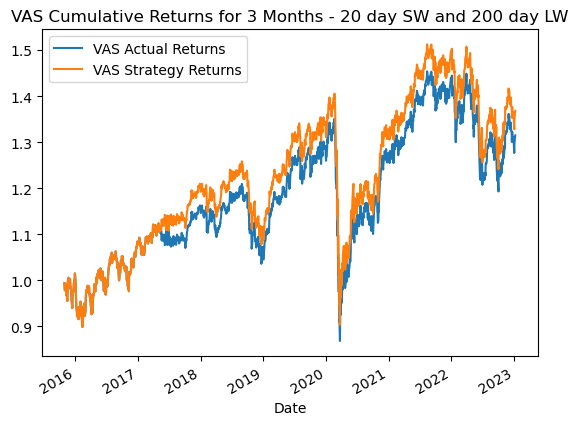

In [57]:
vas_plt_ar_sr = (1 + vas_predictions_df[["VAS Actual Returns", "VAS Strategy Returns"]]).cumprod().plot(title="VAS Cumulative Returns for 3 Months - 20 day SW and 200 day LW")

,SPY Pred,SPY Actual Returns,SPY Strategy Returns,STW Pred,STW Actual Returns,STW Strategy Returns,VAS Pred,VAS Actual Returns,VAS Strategy Returns
Date,,,,,,,,,
2015-10-30,1.0,0.004051,0.004051,1.0,-0.004411,-0.004411,1.0,-0.006544,-0.006544
2015-11-02,1.0,-0.015258,-0.015258,1.0,-0.013897,-0.013897,1.0,-0.015719,-0.015719
2015-11-03,1.0,0.013174,0.013174,1.0,0.014297,0.014297,1.0,0.011407,0.011407
2015-11-04,1.0,-0.001234,-0.001234,1.0,0.000000,0.000000,1.0,0.003007,0.003007
2015-11-05,1.0,0.000611,0.000611,1.0,-0.008055,-0.008055,1.0,-0.006897,-0.006897


<AxesSubplot:title={'center':'Cumulative Returns for all 3 ETFs for 3 Months - 20 day SW and 200 day LW'}, xlabel='Date'>

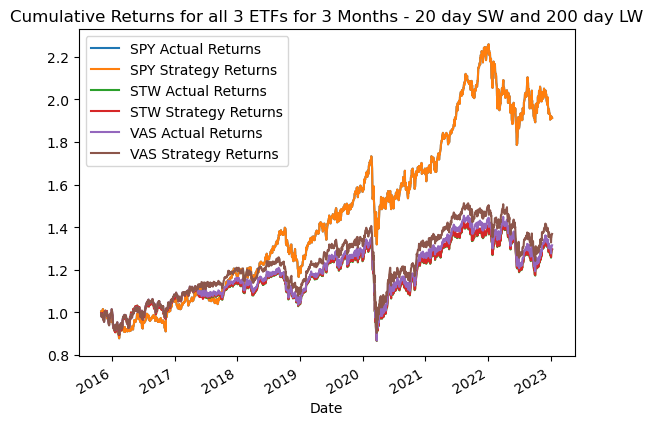

In [58]:
# Cumulative plot for all 3 ETFs

# Concatenate the prediction dataframes of all 3 ETFs

all_predictions_df = pd.concat([spy_predictions_df,stw_predictions_df,vas_predictions_df], axis=1)

display(all_predictions_df.head())

(1 + all_predictions_df[["SPY Actual Returns", "SPY Strategy Returns","STW Actual Returns", "STW Strategy Returns","VAS Actual Returns", "VAS Strategy Returns"]]).cumprod().plot(title="Cumulative Returns for all 3 ETFs for 3 Months - 20 day SW and 200 day LW")

<AxesSubplot:xlabel='Date'>

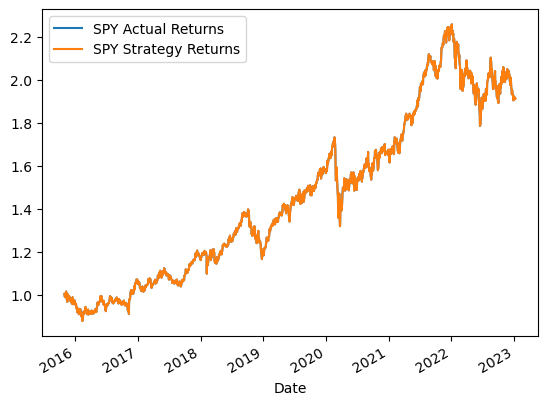

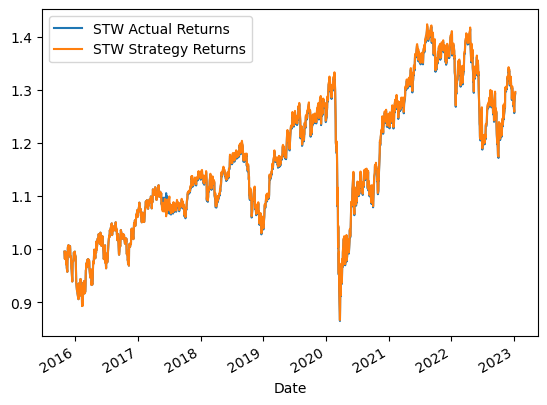

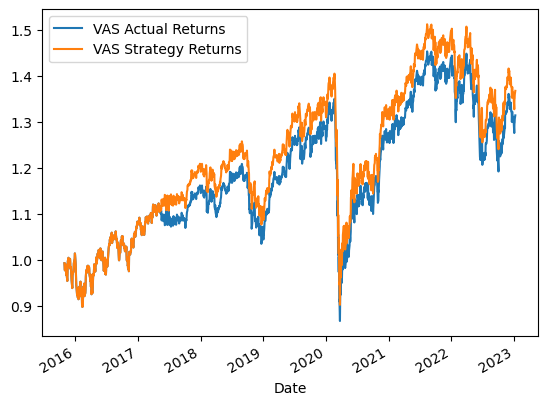

In [59]:
(1 + all_predictions_df[["SPY Actual Returns", "SPY Strategy Returns"]]).cumprod().plot()
(1 + all_predictions_df[["STW Actual Returns", "STW Strategy Returns"]]).cumprod().plot()
(1 + all_predictions_df[["VAS Actual Returns", "VAS Strategy Returns"]]).cumprod().plot()

# Other Classifier Models for VAS

## Using LogisticRegression Model

In [60]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_regression_model = LogisticRegression(random_state=1)

# Fit the model using training data
lrm = logistic_regression_model.fit(X2_train_scaled, y2_train)

# Predict
vas_lrm_predict = lrm.predict(X2_test_scaled)
vas_lrm_predict

from sklearn.metrics import classification_report
print(classification_report(y2_test, vas_lrm_predict))

              precision    recall  f1-score   support

        -1.0       0.44      0.79      0.57       811
         1.0       0.53      0.19      0.28      1005

    accuracy                           0.46      1816
   macro avg       0.49      0.49      0.43      1816
weighted avg       0.49      0.46      0.41      1816



/usr/local/anaconda3/envs/cenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [61]:
vas_lrm_pred_df = pd.DataFrame(index=X2_test.index)

# Add the SVM model predictions to the DataFrame
vas_lrm_pred_df['VAS Pred'] = vas_lrm_predict

# Add the actual returns to the DataFrame
vas_lrm_pred_df['VAS Actual Returns'] = etf_df["VAS Actual Returns"]

# Add the strategy returns to the DataFrame
vas_lrm_pred_df['VAS Strategy Returns'] = (vas_lrm_pred_df["VAS Actual Returns"] * vas_lrm_pred_df['VAS Pred'])

# Review the DataFrame
display(vas_lrm_pred_df.head())
display(vas_lrm_pred_df.tail())

,VAS Pred,VAS Actual Returns,VAS Strategy Returns
Date,,,
2015-10-30,1.0,-0.006544,-0.006544
2015-11-02,1.0,-0.015719,-0.015719
2015-11-03,1.0,0.011407,0.011407
2015-11-04,1.0,0.003007,0.003007
2015-11-05,1.0,-0.006897,-0.006897


,VAS Pred,VAS Actual Returns,VAS Strategy Returns
Date,,,
2023-01-03,-1.0,-0.021437,0.021437
2023-01-04,-1.0,0.015964,-0.015964
2023-01-05,-1.0,0.001491,-0.001491
2023-01-06,-1.0,0.006299,-0.006299
2023-01-09,-1.0,0.006032,-0.006032


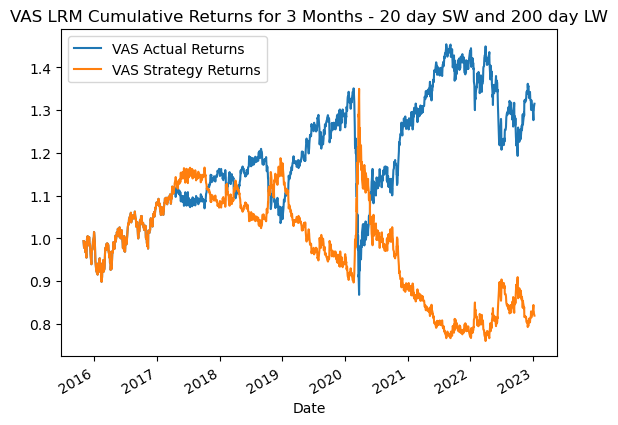

In [62]:
vas_lrm_plt_ar_sr = (1 + vas_lrm_pred_df[["VAS Actual Returns", "VAS Strategy Returns"]]).cumprod().plot(title="VAS LRM Cumulative Returns for 3 Months - 20 day SW and 200 day LW")

## Using ADA Boost Classifier

In [63]:
# Import a new classifier from SKLearn
from sklearn.ensemble import AdaBoostClassifier

# Initiate the model instance
abc = AdaBoostClassifier(n_estimators=1000,learning_rate=1)

In [64]:
# Fit the model using the training data
vas_abc_model = abc.fit(X2_train_scaled, y2_train)

# Use the testing dataset to generate the predictions for the new model
vas_abc_pred = vas_abc_model.predict(X2_test_scaled)

# Review the model's predicted values
print(vas_abc_pred)


/usr/local/anaconda3/envs/cenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[-1. -1.  1. ... -1. -1. -1.]


In [65]:
# Use a classification report to evaluate the model using the predictions and testing data
vas_abc_cr = classification_report(y2_test,vas_abc_pred)

# Print the classification report
print(vas_abc_cr)

              precision    recall  f1-score   support

        -1.0       0.44      0.83      0.58       811
         1.0       0.54      0.16      0.25      1005

    accuracy                           0.46      1816
   macro avg       0.49      0.50      0.41      1816
weighted avg       0.50      0.46      0.40      1816



In [66]:
vas_ada_pred_df = pd.DataFrame(index=X2_test.index)

# Add the SVM model predictions to the DataFrame
vas_ada_pred_df['VAS Pred'] = vas_abc_pred

# Add the actual returns to the DataFrame
vas_ada_pred_df['VAS Actual Returns'] = etf_df["VAS Actual Returns"]

# Add the strategy returns to the DataFrame
vas_ada_pred_df['VAS Strategy Returns'] = (vas_ada_pred_df["VAS Actual Returns"] * vas_ada_pred_df['VAS Pred'])

# Review the DataFrame
display(vas_ada_pred_df.head())
display(vas_ada_pred_df.tail())

,VAS Pred,VAS Actual Returns,VAS Strategy Returns
Date,,,
2015-10-30,-1.0,-0.006544,0.006544
2015-11-02,-1.0,-0.015719,0.015719
2015-11-03,1.0,0.011407,0.011407
2015-11-04,1.0,0.003007,0.003007
2015-11-05,1.0,-0.006897,-0.006897


,VAS Pred,VAS Actual Returns,VAS Strategy Returns
Date,,,
2023-01-03,-1.0,-0.021437,0.021437
2023-01-04,-1.0,0.015964,-0.015964
2023-01-05,-1.0,0.001491,-0.001491
2023-01-06,-1.0,0.006299,-0.006299
2023-01-09,-1.0,0.006032,-0.006032


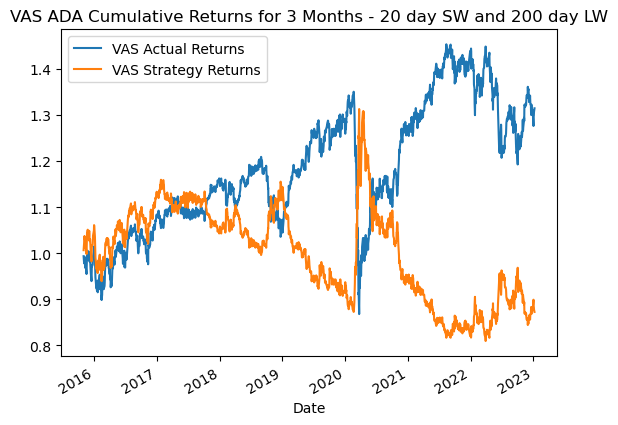

In [67]:
vas_ada_plt_ar_sr = (1 + vas_ada_pred_df[["VAS Actual Returns", "VAS Strategy Returns"]]).cumprod().plot(title="VAS ADA Cumulative Returns for 3 Months - 20 day SW and 200 day LW")